In [12]:
import h5py
import numpy as np
import numexpr as ne
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage.morphology as morphology
from sklearn.neighbors import KernelDensity
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from scipy import interp

%matplotlib inline

ImportError: No module named 'sklearn'

In [5]:
! sudo pip3 install h5py

[sudo] password for groza: 


In [2]:
!ptdump /home/malyugina/Documents/recurrent_network/simon/compute_data/all_pulses_only_N_for_exp.h5

Traceback (most recent call last):
  File "/usr/local/bin/ptdump", line 5, in <module>
    from pkg_resources import load_entry_point
  File "/home/malyugina/.local/lib/python3.5/site-packages/pkg_resources/__init__.py", line 2991, in <module>
    @_call_aside
  File "/home/malyugina/.local/lib/python3.5/site-packages/pkg_resources/__init__.py", line 2977, in _call_aside
    f(*args, **kwargs)
  File "/home/malyugina/.local/lib/python3.5/site-packages/pkg_resources/__init__.py", line 3004, in _initialize_master_working_set
    working_set = WorkingSet._build_master()
  File "/home/malyugina/.local/lib/python3.5/site-packages/pkg_resources/__init__.py", line 662, in _build_master
    ws.require(__requires__)
  File "/home/malyugina/.local/lib/python3.5/site-packages/pkg_resources/__init__.py", line 970, in require
    needed = self.resolve(parse_requirements(requirements))
  File "/home/malyugina/.local/lib/python3.5/site-packages/pkg_resources/__init__.py", line 856, in resolve
    rai

In [3]:
path0 = '/home/malyugina/Documents/iitp/recurrent_network/simon/compute_data/all_pulses_only_N_for_exp.h5'
f = h5py.File(path0, 'r')

sleep = pd.read_stata('/home/malyugina/Documents/iitp/recurrent_network/network/learning/data/sleep.dta')

In [4]:
persons = f['persons']
pulses = f['pulses']

gidn = persons['gidn']
measurement = persons['measurement_start']

# create data for sleep recognition

In [5]:
gidn_for_Sleep = []
gidn_for_test = []
pulse_for_sleep = {}
for i, gidn_i in enumerate(gidn):
    if sleep[sleep.GIDN == gidn_i].empty:
        continue
    if gidn_i == 221938:
        continue
    if pd.isnull(sleep[sleep.GIDN == gidn_i].Hol_Sleep_Duration_Trend).values:
        continue
    if ~ pd.isnull(sleep[sleep.GIDN == gidn_i].Hol_Sleep_Duration_Diary).values:
        gidn_for_test.append(gidn_i)
        pulse_for_sleep[gidn_i] = pulses[i] + measurement[i]
        continue
    gidn_for_Sleep.append(gidn_i)
    pulse_for_sleep[gidn_i] = pulses[i] + measurement[i]


In [6]:
val_gidn = np.array(gidn_for_test)[:300]
te_gidn = np.array(gidn_for_test)[300:600]
tr_gidn = np.array(gidn_for_test)[600:]

In [7]:
tr_gidn = np.hstack((tr_gidn, np.array(gidn_for_Sleep)))
all_gidn_for_sleep = np.hstack((np.array(gidn_for_test), np.array(gidn_for_Sleep)))

In [8]:
sleep_start = {}
sleep_end = {}
sleep_for_peaks = {}
begin_gidn = {}
for i in all_gidn_for_sleep:
    start = sleep[sleep.GIDN == i].Hol_Sleep_Start_Trend.values
    end = sleep[sleep.GIDN == i].Hol_Sleep_End_Trend.values
    if min(pulse_for_sleep[i]) > start:
        start = start + 1000*60*60*24
    if min(pulse_for_sleep[i]) > end:
        end = end + 1000*60*60*24
    if start > end: #-1 gidn
        continue
        
    sleep_start[i] = start
    sleep_end[i] = end
    peak_sleep_i = np.ones((len(pulse_for_sleep[i]), 1))
    peak_sleep_i[pulse_for_sleep[i] < start] = 0
    peak_sleep_i[pulse_for_sleep[i] > end] = 0
    sleep_for_peaks[i] = peak_sleep_i
    begin_gidn_i = np.zeros((len(pulse_for_sleep[i]), 1))
    begin_gidn_i[0] = 1
    begin_gidn[i] = begin_gidn_i

In [9]:
step = 200
y_with_feature = {}
x_with_feature = {}
for gidn_i in all_gidn_for_sleep:
    delay = pulse_for_sleep[gidn_i][1:] - pulse_for_sleep[gidn_i][:-1]
    mean_ = np.mean(delay)
    std_ = np.std(delay)
    y_with_feature_i = []
    x_with_feature_i = []
    for i in range(0, len(delay) - step, step):
        if any(sleep_for_peaks[gidn_i][i : i+step] > 0):
            y_with_feature_i.append(1)
        else:
            y_with_feature_i.append(0)
        x_with_feature_i.append(np.array([mean_, std_, np.mean(delay[i:i+step]),
                                np.std(delay[i:i+step])]))
    y_with_feature[gidn_i] = np.array(y_with_feature_i).reshape((len(y_with_feature_i)), 1)
    x_with_feature[gidn_i] = np.array(x_with_feature_i)

step = 300000
y_with_feature_50000 = {}
x_with_feature_50000 = {}
len_ = []
for gidn_i in all_gidn_for_sleep:
    delay = pulse_for_sleep[gidn_i][1:] - pulse_for_sleep[gidn_i][:-1]
    mean_ = np.mean(delay)
    std_ = np.std(delay)
    y_with_feature_i = []
    x_with_feature_i = []
    for i in range(int(pulse_for_sleep[gidn_i][0]), int(pulse_for_sleep[gidn_i][-1]) - step, step):       
        ind = [np.array((pulse_for_sleep[gidn_i] > i, pulse_for_sleep[gidn_i] < i + step)).all(axis = 0)] 
        len_.append(len(sleep_for_peaks[gidn_i][ind]))
        if len(sleep_for_peaks[gidn_i][ind]) < 10:
            continue
        if any(sleep_for_peaks[gidn_i][ind]):
            y_with_feature_i.append(1)
        else:
            y_with_feature_i.append(0)
        x_with_feature_i.append(np.array([mean_, std_, np.mean(delay[ind]),
                                np.std(delay[ind])]))
    
    y_with_feature_50000[gidn_i] = np.array(y_with_feature_i).reshape((len(y_with_feature_i)), 1)
    x_with_feature_50000[gidn_i] = np.array(x_with_feature_i) 
        

In [10]:
def get_data_for_train(gidn):
#     X = np.array([[], [], [], [], []]).T
    X = np.array([[], [], [], []]).T
    Y = np.array([[]]).T
    for i in gidn:
        Y = np.vstack((Y, y_with_feature[i]))
        X = np.vstack((X, x_with_feature[i]))
    return(X, Y)

def get_data_for_train(gidn):
    X = np.array([[]]).T
    Y = np.array([[]]).T
    for i in gidn:
        Y = np.vstack((Y, sleep_for_peaks[i][:-1]))

        X = np.vstack((X, np.array([pulse_for_sleep[i][1:] - pulse_for_sleep[i][:-1]]).reshape(len(pulse_for_sleep[i])-1, 1)))
    return(X, Y)

In [11]:
(te_X, te_Y) = get_data_for_train(te_gidn)
(tr_X, tr_Y) = get_data_for_train(tr_gidn)
(val_X, val_Y) = get_data_for_train(val_gidn)

In [12]:
print (tr_X.shape)

(558003, 4)


te_X_inv = te_X[::-1]
te_Y_inv = te_Y[::-1]
tr_X_inv = tr_X[::-1]
tr_Y_inv = tr_Y[::-1]
val_X_inv = val_X[::-1]
val_Y_inv = val_Y[::-1]

In [13]:
def data_for_lstm (X, y, window=200):
    X_new = []
    y_new = []
    window = window
    step = 1
    for i in range(0, len(X)-window, step):
        X_new.append(X[i:i + window])
        y_new.append(y[i + window/2])
    X_new = np.array(X_new)
    y_new = np.array(y_new)
    return (X_new, y_new)

(X_train, y_train) = data_for_lstm(tr_X_inv, tr_Y_inv)
(X_val, y_val) = data_for_lstm(val_X_inv, val_Y_inv)
(X_test, y_test) = data_for_lstm(te_X_inv, te_Y_inv)

In [14]:
(X_train, y_train) = data_for_lstm(tr_X, tr_Y)
(X_val, y_val) = data_for_lstm(val_X, val_Y)
(X_test, y_test) = data_for_lstm(te_X, te_Y)

/home/malyugina/.local/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [15]:
X_train.shape

(557803, 200, 4)

In [16]:
X_test[:, :, :].shape

(148917, 200, 4)

new_a = np.zeros((a.shape))
for i, a_i in enumerate(a):
    for j, a_j in enumerate(a):
        #print (i, j, a_j, -(((j-i)**2)/100.), (np.exp(-((j-i)**2)/10.)))
        new_a[i] = new_a[i] + a_j*(np.exp(-((j-i)**2)/5))

y_test_3d

def y_to_3d(y):
    y = np.vstack((y[1:]-y[:-1], [-1]))
    new_y = np.zeros((len(y), 2))
    for i, y_i in enumerate(y):
        if y_i == 1:
            new_y[i, 0] = 1
        if y_i == -1:
            new_y[i, 1] = 1
    new_y = morphology.grey_dilation(new_y, 5)
    gaus_y = np.zeros((new_y.shape))
    for i in range(2):
        for k in range(len(new_y[:, i])):
            for j, a_j in enumerate(new_y[:, i]):
                #print (i, k, j)
                gaus_y[k, i] = gaus_y[k, i] + a_j*(np.exp(-((j-k)**2)/5))
    return gaus_y

y_train_3d = y_to_3d(y_train)
y_val_3d = y_to_3d(y_val)
y_test_3d = y_to_3d(y_test)

# test

weight_class = {}
weight_class[0] = 0.0001
weight_class[1] = 0.9999

In [17]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from  keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.utils.visualize_util import plot

Using Theano backend.
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '29525' (I am process '30493')
Using gpu device 0: GeForce GTX TITAN X (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5105)
/usr/local/lib/python3.5/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [18]:
checkpointer = ModelCheckpoint(filepath="exp_for_paper_cnn_4.hdf5", 
                               verbose=1, save_best_only=True)

numbers_filter = 30
filter_length = 5
in_out_neurons = 1
hidden_neurons = 500

model = Sequential()
model.add(Convolution1D(numbers_filter, filter_length, init='uniform', activation='relu', border_mode='valid', 
                       input_shape=X_train.shape[1:]))
model.add(Convolution1D(numbers_filter, filter_length, init='uniform', activation='relu', border_mode='valid'))
model.add(MaxPooling1D(10))
model.add(Dropout(0.25))
# model.add(LSTM(hidden_neurons, input_dim=4, return_sequences=False))
# model.add(Dense(in_out_neurons, input_dim=hidden_neurons))
# model.add(Activation("sigmoid"))
model.add(Flatten())
model.add(Dense(300))
model.add(Activation("sigmoid"))
model.add(Dense(1))
model.add(Activation("sigmoid"))
model.compile(loss="mean_squared_error", optimizer="Adam")
# model.compile(loss="mean_squared_error", optimizer="rmsprop")

# model.load_weights('exp_for_paper_cnn_2.hdf5')

model.fit(X_train[:, :, :], y_train, batch_size=1000, nb_epoch=30, 
          validation_data=(X_val[:, :, :], y_val), callbacks=[checkpointer])


Train on 557803 samples, validate on 151755 samples
Epoch 1/30
557803/557803 [==============================] - 19s - loss: 0.0674 - val_loss: 0.0557
Epoch 2/30
557803/557803 [==============================] - 19s - loss: 0.0501 - val_loss: 0.0529
Epoch 3/30
557803/557803 [==============================] - 19s - loss: 0.0470 - val_loss: 0.0517
Epoch 4/30
557803/557803 [==============================] - 19s - loss: 0.0452 - val_loss: 0.0512
Epoch 5/30
557803/557803 [==============================] - 19s - loss: 0.0428 - val_loss: 0.0489
Epoch 6/30
557803/557803 [==============================] - 19s - loss: 0.0410 - val_loss: 0.0507
Epoch 7/30
557803/557803 [==============================] - 19s - loss: 0.0397 - val_loss: 0.0468
Epoch 8/30
557803/557803 [==============================] - 19s - loss: 0.0386 - val_loss: 0.0480
Epoch 9/30
557803/557803 [==============================] - 19s - loss: 0.0378 - val_loss: 0.0487
Epoch 10/30
557803/557803 [==============================] - 19s -

KeyboardInterrupt: 

In [148]:
predicted = model.predict(X_test)

In [46]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from  keras.callbacks import ModelCheckpoint

model = Sequential()

in_out_neurons = 1
hidden_neurons = 100

model = Sequential()
model.add(LSTM(hidden_neurons, input_dim=5, return_sequences=False))
model.add(Dense(in_out_neurons, input_dim=hidden_neurons))
model.add(Activation("sigmoid"))
model.compile(loss="mean_squared_error", optimizer="rmsprop")

model.load_weights('weights_features_step_1_with_val_h_100_step_200_sigmoid_mean_sq_epoch_500.hdf5')

In [146]:
predicted = model.predict(X_test)

AttributeError: 'Sequential' object has no attribute '_predict'

In [136]:
rate = 0.3


binary_predicted = np.zeros((predicted.shape))
binary_predicted[predicted < rate] = 0
binary_predicted[predicted >= rate] = 1

res = binary_predicted - y_test
fn = len(res[res == -1])*1./len(y_test)
fp = len(res[res == 1])*1./len(y_test)
tp = len(res[np.array((res == 0, y_test == 1)).all(axis = 0)])*1./len(y_test)
tn = len(res[np.array((res == 0, y_test == 0)).all(axis = 0)])*1./len(y_test)

In [137]:
print(fn, fp, tp, tn)
print ('acc', tp+tn, 'tpr', tp/(tp+fn), 'tnr', tn/(tn+fp))

0.030769746434496974 0.07619702022825924 0.2567799024619149 0.6362533308753289
acc 0.8930332333372437 tpr 0.8929932741959925 tnr 0.8930493611095429


In [47]:
print(fn, fp, tp, tn)
print ('acc', tp+tn, 'tpr', tp/(tp+fn), 'tnr', tn/(tn+fp))

0.036980659615828144 0.060538367763829856 0.2437876840960759 0.6586932885242661
acc 0.902480972620342 tpr 0.8682876455125798 tnr 0.9158291111986587


In [ ]:
for i, y_i in enumerate(binary_predicted):
    if y_i[0] == 1:
        print '0', i
    if y_i[1] == 1:
        print '1', i

In [ ]:
y_test[55280:55310]

In [ ]:
print(fn, fp, tp, tn)
print ('acc', tp+tn, 'tpr', tp/(tp+fn), 'tnr', tn/(tn+fp))

test with morhpology

In [41]:
one_ = 0
max_ = 0
for i in binary_predicted:
    if i == 1:
        max_ = max_ + 1
    else:
        if max_ < 30 and max_ > 0:
            one_ = one_ + 1
        max_ = 0
        
print (one_)

615


In [49]:
new_predicted = np.zeros((binary_predicted.shape))

import scipy.ndimage.morphology as morphology
new_predicted = morphology.grey_opening(binary_predicted, size=10)
new_predicted = morphology.grey_closing(new_predicted, size=50)

res = new_predicted - y_test
fn = len(res[res == -1])*1./len(y_test)
fp = len(res[res == 1])*1./len(y_test)
tp = len(res[np.array((res == 0, y_test == 1)).all(axis = 0)])*1./len(y_test)
tn = len(res[np.array((res == 0, y_test == 0)).all(axis = 0)])*1./len(y_test)

In [50]:
print(fn, fp, tp, tn)
print ('acc', tp+tn, 'tpr', tp/(tp+fn), 'tnr', tn/(tn+fp))

0.037613258212250006 0.05755988270567691 0.24315508549965406 0.661671773582419
acc 0.904826859082073 tpr 0.8660345475028164 tnr 0.9199703152629023


test 1 gidn

In [ ]:
i = te_gidn[111]
x_test_small = np.hstack([x_with_feature[i], begin_gidn[i][:len(x_with_feature[i])]])
x_test_small_ltsm, y_test_small_ltsm = data_for_lstm(x_test_small, y_with_feature[i])
predicted_small = model.predict(x_test_small_ltsm)


rate = 0.5

predicted_small[predicted_small < rate] = 0
predicted_small[predicted_small >= rate] = 1

new_predicted = np.zeros((predicted.shape))

import scipy.ndimage.morphology as morphology
new_predicted = morphology.grey_opening(predicted_small, size=10)
new_predicted = morphology.grey_closing(new_predicted, size=50)

In [ ]:
np.hstack((predicted_small, y_test_small_ltsm))[500:1000]

count erroro

In [51]:
err_start = []
err_end = []
count_start = []
count_end = []
i_start_exp = 0
i_start_real = 0
i_end_exp = 0
i_end_real = 0
i_count_start = 0
i_count_end = 0
count = 0
x_tmp = []
y_tmp = []
ind_real = y_test[1:] - y_test[:-1]
ind_exp = new_predicted[1:] - new_predicted[:-1]
for i, start_gidn in enumerate(te_X[:, 4][100:-101]) :
    if start_gidn == 1:
        err_start.append(i_start_real - i_start_exp)
        err_end.append(i_end_real - i_end_exp)
        count_start.append(i_count_start)
        count_end.append(i_count_end)
        i_end_exp = 0
        i_end_real = 0
        i_start_exp = 0
        i_start_real = 0
        i_count_start = 0
        i_count_end = 0
        count = count + 1
    if ind_real[i] == 1:
        i_start_real = i+100
    if ind_real[i] == -1:
        i_end_real = i+100
    if ind_exp[i] == 1:
        i_start_exp = i+100
        i_count_start = i_count_start + 1
    if ind_exp[i] == -1:
        i_end_exp = i+100
        i_count_end = i_count_end + 1
    if count == 197:
        print (y_test[i+100], new_predicted[i+100])
        x_tmp.append(X_test[i+100])
        y_tmp.append(y_test[i+100])
    
err_start = np.array(err_start)
err_end = np.array(err_end)


[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.] [ 0.]
[ 0.

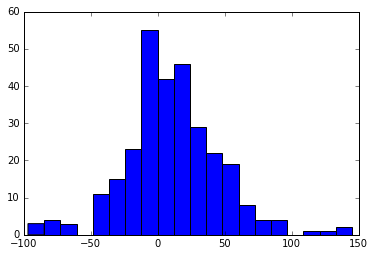

27.4828767123 25.196278426


In [52]:
plt.hist(err_start[err_start < 300], 20)
plt.show()
print (np.mean(abs(err_start[abs(err_start) < 300])), np.std(abs(err_start[abs(err_start) < 300])))

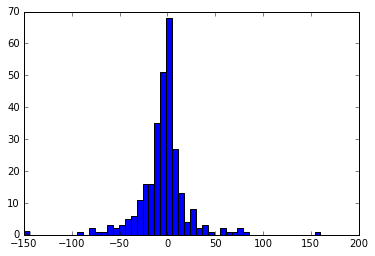

15.9791666667 20.9425367076


In [53]:
plt.hist(err_end[abs(err_end) < 300], 50)
plt.show()
print (np.mean(abs(err_end[abs(err_end) < 300])), np.std(abs(err_end[abs(err_end) < 300])))

In [54]:
for i, err in enumerate(err_end):
    if err > 100:
        print (i, err, count_end[i], err_start[i], count_start[i])

41 21052 0 -15 1
42 160 2 44 1
66 33214 0 33077 0
99 320 1 145 1
113 57253 0 57101 0
118 60083 0 59739 0
197 99713 0 99501 0
213 107825 0 107694 0
220 111437 0 111345 0
234 300 1 134 1
267 135594 0 -26 1
283 143542 0 143417 0


In [55]:
for i, err in enumerate(err_start):
    if err > 100:
        print (i, err_end[i], count_end[i], err, count_start[i])

66 33214 0 33077 0
78 -20 1 112 1
99 320 1 145 1
113 57253 0 57101 0
118 60083 0 59739 0
197 99713 0 99501 0
213 107825 0 107694 0
214 78 1 129 1
220 111437 0 111345 0
234 300 1 134 1
283 143542 0 143417 0


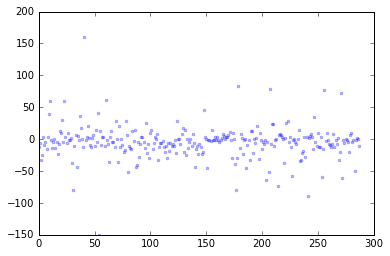

In [57]:
plt.plot(err_end[abs(err_end) < 300], '.', alpha = 0.3)

avtomatic test

In [22]:
plt.rcParams['figure.figsize'] = (20,10)

step =  300


/home/malyugina/.local/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


X.test.shape =  (148817, 300, 4)
Train on 557703 samples, validate on 151655 samples
Epoch 1/12
557703/557703 [==============================] - 40s - loss: 0.0658 - val_loss: 0.0502
Epoch 2/12
557703/557703 [==============================] - 41s - loss: 0.0443 - val_loss: 0.0467
Epoch 3/12
557703/557703 [==============================] - 40s - loss: 0.0416 - val_loss: 0.0466
Epoch 4/12
557703/557703 [==============================] - 40s - loss: 0.0401 - val_loss: 0.0453
Epoch 5/12
557703/557703 [==============================] - 41s - loss: 0.0386 - val_loss: 0.0454
Epoch 6/12
557703/557703 [==============================] - 41s - loss: 0.0386 - val_loss: 0.0459
Epoch 7/12
557703/557703 [==============================] - 41s - loss: 0.0389 - val_loss: 0.0488
Epoch 8/12
557703/557703 [==============================] - 41s - loss: 0.0387 - val_loss: 0.0463
Epoch 9/12
557703/557703 [==============================] - 40s - loss: 0.0394 - val_loss: 0.0495
Epoch 10/12
557703/557703 [======

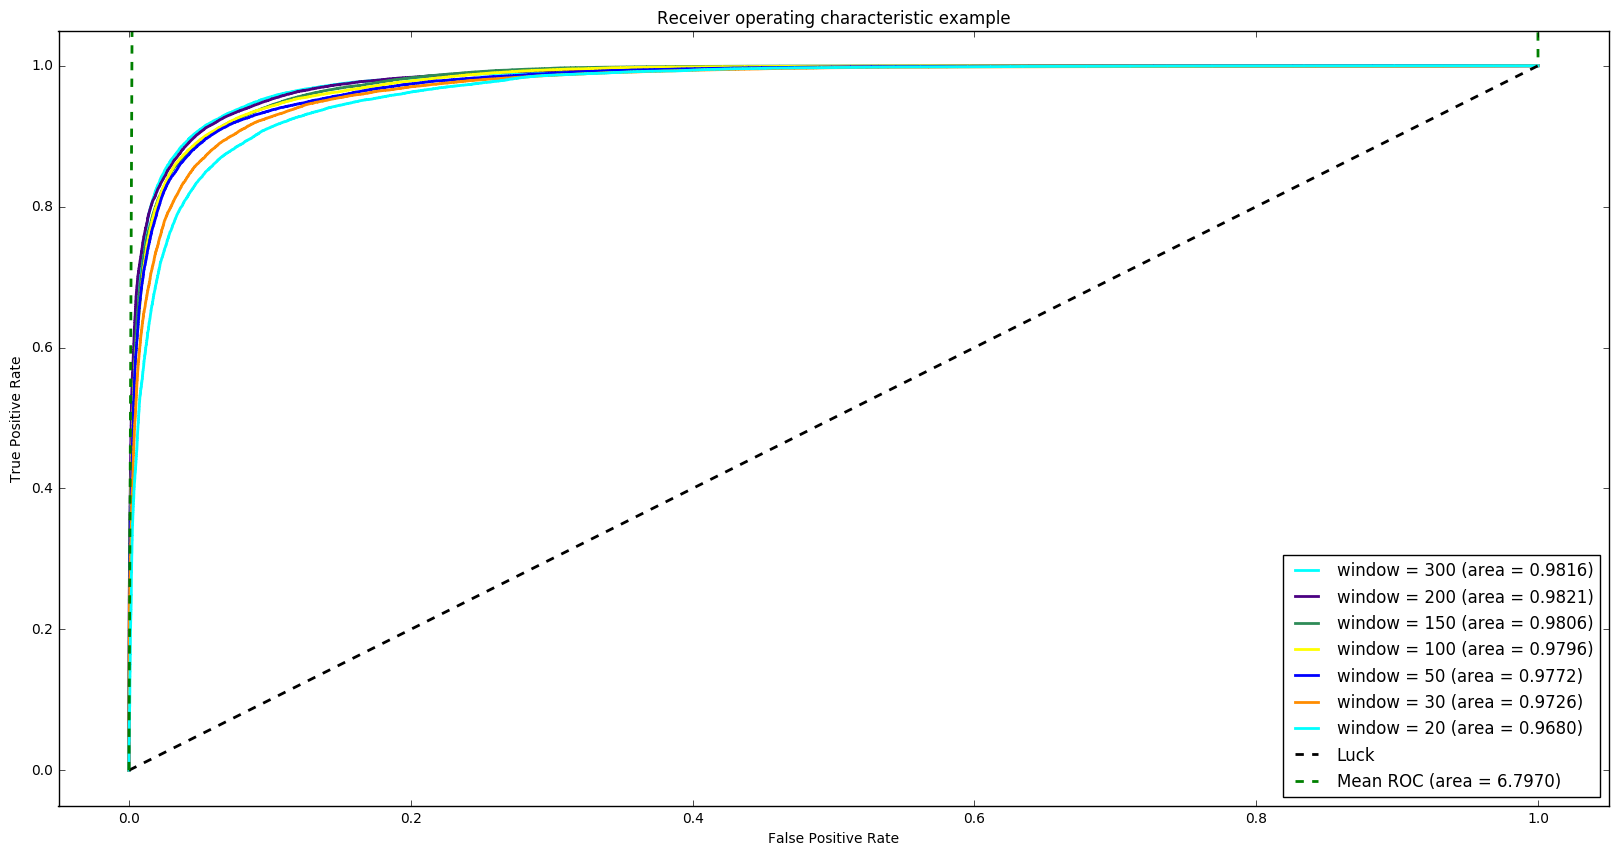

In [39]:
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
steps = [20, 30, 50, 100, 150, 200, 300][::-1]
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
lw = 2
numbers_filter = 40
filter_length = 5



for step, color in zip(steps, colors):
    print ('step = ', step)
    y_with_feature = {}
    x_with_feature = {}
    
    (X_train, y_train) = data_for_lstm(tr_X, tr_Y, step)
    (X_val, y_val) = data_for_lstm(val_X, val_Y, step)
    (X_test, y_test) = data_for_lstm(te_X, te_Y, step)
    print ('X.test.shape = ', X_test.shape)
    
    checkpointer = ModelCheckpoint(filepath="CNN_experimenp_4_step_" + str(step) +".hdf5", 
                               verbose=1, save_best_only=True)



    model = Sequential()
    model.add(Convolution1D(numbers_filter, filter_length, init='uniform', activation='relu', border_mode='valid', 
                           input_shape=X_train.shape[1:]))
    model.add(Convolution1D(numbers_filter, filter_length, init='uniform', activation='relu', border_mode='valid'))
    model.add(MaxPooling1D(10))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(300))
    model.add(Activation("sigmoid"))
    model.add(Dense(1))
    model.add(Activation("sigmoid"))
    model.compile(loss="mean_squared_error", optimizer="Adam")


    model.fit(X_train[:, :, :], y_train, batch_size=1000, nb_epoch=10+int(600/step), 
              validation_data=(X_val[:, :, :], y_val), callbacks=[checkpointer])

    
    predicted = model.predict(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, predicted)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='window = %d (area = %0.4f)' % (step, roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.4f)' % mean_auc, lw=lw)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('ROC_cnn_num_filteres_40_filteres_len_5_21d_curve_for_dif_step.png')
plt.show()